In [ ]:
import os
import glob
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

# Set environment variables to avoid library conflicts and configure CUDA
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# 数据预处理

In [ ]:
# Function to check if a file corresponds to the left side ("L")
def is_left_file(filename):
    return os.path.basename(filename).startswith("L")

# Function to find columns with all zeros in trajectory CSV files within a folder
def find_all_zero_columns(folder):
    files = glob.glob(os.path.join(folder, '*_trajectory.csv'))
    all_zero_cols = set()

    for file in files:
        is_left = is_left_file(file) # Check if the file is for the left side
        prefix = 'L' if is_left else 'R' # Prefix for columns based on side (L or R)

        df = pd.read_csv(file)
        relevant_cols = [col for col in df.columns if col.startswith(prefix)]

        df_subset = df[relevant_cols]
        zero_cols = df_subset.columns[(df_subset == 0).all()].tolist()
        all_zero_cols.update(zero_cols)

    return all_zero_cols

# Identify markers with all-zero values across training and validation datasets and merge results
train_zero_cols = find_all_zero_columns('random_dataset/train')
val_zero_cols = find_all_zero_columns('random_dataset/val')
merged_zero_cols = sorted(train_zero_cols.union(val_zero_cols))

print("Markers with all zero:")
print(', '.join(merged_zero_cols))

# remove L(R)KNM, L(R)MED, L(R)SHO, L(R)SMH

Markers with all zero:
LKNM_X, LKNM_X', LKNM_X'', LKNM_Y, LKNM_Y', LKNM_Y'', LKNM_Z, LKNM_Z', LKNM_Z'', LMED_X, LMED_X', LMED_X'', LMED_Y, LMED_Y', LMED_Y'', LMED_Z, LMED_Z', LMED_Z'', LSMH_X, LSMH_X', LSMH_X'', LSMH_Y, LSMH_Y', LSMH_Y'', LSMH_Z, LSMH_Z', LSMH_Z'', RKNM_X, RKNM_X', RKNM_X'', RKNM_Y, RKNM_Y', RKNM_Y'', RKNM_Z, RKNM_Z', RKNM_Z'', RMED_X, RMED_X', RMED_X'', RMED_Y, RMED_Y', RMED_Y'', RMED_Z, RMED_Z', RMED_Z'', RSHO_X, RSHO_X', RSHO_X'', RSHO_Y, RSHO_Y', RSHO_Y'', RSHO_Z, RSHO_Z', RSHO_Z'', RSMH_X, RSMH_X', RSMH_X'', RSMH_Y, RSMH_Y', RSMH_Y'', RSMH_Z, RSMH_Z', RSMH_Z''


In [ ]:
# ========== Data Loading Functions ==========

# Define excluded and fixed marker points for trajectory processing
EXCLUDED_POINTS = ['LFHD', 'RFHD', 'LBHD', 'RBHD', 'C7', 'T10', 'CLAV', 'RBAK'] # Markers to exclude
NUM_FEATURES = 9 # Number of features per marker (position, velocity, acceleration in 3D)
FIXED_POINTS = ['LANK', 'LHEE', 'LKNE', 'LTOE', 'LTHI', 'LTIAD', 'LTIAP', 'LTIB', 'LTHAD', 'LTHAP', 'LPSI', 'LASI', 'LFMH', 'LVMH', 
                'RANK', 'RHEE', 'RKNE', 'RTOE', 'RTHI', 'RTIAD', 'RTIAP', 'RTIB', 'RTHAD', 'RTHAP', 'RPSI', 'RASI', 'RFMH', 'RVMH'] # Fixed marker points for left (L) and right (R) sides

def is_left_file(filename):
    return os.path.basename(filename).startswith("L")

# Function to pair trajectory and model files based on matching filenames
def pair_files(folder_path):
    traj_files = sorted(glob.glob(os.path.join(folder_path, '*_trajectory.csv')))
    model_files = sorted(glob.glob(os.path.join(folder_path, '*_model.csv')))
    pairs = []
    for traj in traj_files:
        base = os.path.basename(traj).replace('_trajectory.csv', '')
        model = os.path.join(folder_path, base + '_model.csv')
        if os.path.exists(model):
            pairs.append((traj, model))
    return pairs

# Function to read trajectory data from a CSV file and format it into tensors
def read_trajectory(traj_path, is_left, selected_markers=None):
    df = pd.read_csv(traj_path)
    suffixes = ['X', 'Y', 'Z', "X'", "Y'", "Z'", "X''", "Y''", "Z''"] # Suffixes for marker features
    prefix = 'L' if is_left else 'R' # Prefix for left or right side

    if selected_markers is not None:
        point_list = [f"{prefix}{m}" for m in selected_markers] # Prefix selected markers
    else:
        point_list = [p for p in FIXED_POINTS if p.startswith(prefix)] # Use fixed points for the side

    # Select relevant columns and reshape data for model input
    cols = [f"{p}_{s}" for p in point_list for s in suffixes if f"{p}_{s}" in df.columns]
    X = df[cols].values.reshape(-1, len(point_list), NUM_FEATURES) # Reshape to (T, N, D)
    return X

# Function to read Knee Adduction Moment (KAM) values from model file
def read_kam(model_path, is_left):
    df = pd.read_csv(model_path)
    col = 'LKneeMoment_Y' if is_left else 'RKneeMoment_Y'
    return df[col].values

# ========== Dataset Class ==========

# Custom PyTorch Dataset class for loading KAM data
class KAMDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, selected_markers=None):
        self.data = [] # List to store dataset samples
        pairs = pair_files(folder_path) # Pair trajectory and model files

        for traj_path, model_path in pairs:
            is_left = is_left_file(traj_path)

            X = read_trajectory(traj_path, is_left, selected_markers)
            Y = read_kam(model_path, is_left)

            input_tensor = torch.tensor(X, dtype=torch.float32)
            target_tensor = torch.tensor(Y, dtype=torch.float32)
            filename = os.path.basename(model_path)

            self.data.append({
                'input': input_tensor,
                'target': target_tensor,
                'filename': filename
            })

        self.selected_markers = selected_markers
        print(f"Loaded {len(self.data)} samples (using {X.shape[1]} markers)")

    def __len__(self):
        return len(self.data) # Return dataset size

    def __getitem__(self, idx):
        return self.data[idx] # Return dataset sample

# ========== collate_fn ==========

# Custom collate function for handling variable-length sequences in a batch
def collate_fn(batch):
    inputs = [item['input'] for item in batch]
    targets = [item['target'] for item in batch]
    lengths = [x.shape[0] for x in inputs]
    max_len = max(lengths)

    # Pad sequences to uniform length
    padded_inputs = pad_sequence(inputs, batch_first=True)  # (B, T, N, D)
    padded_targets = pad_sequence([y.unsqueeze(-1) for y in targets], batch_first=True).squeeze(-1)  # (B, T)

    # Create padding mask to indicate valid frames
    mask = torch.zeros((len(batch), max_len), dtype=torch.bool)
    for i, l in enumerate(lengths):
        mask[i, :l] = 1

    return padded_inputs, padded_targets, mask

# === Build Adjacency Matrix ===

# Define the edges representing connections between markers for left and right legs
edges = [
    # Left leg connections
    ('LTOE', 'LFMH'), ('LTOE', 'LVMH'), ('LTOE', 'LHEE'), ('LANK', 'LHEE'), ('LANK', 'LTOE'),
    ('LANK', 'LTIAD'), ('LTIB', 'LTIAP'), ('LTIB', 'LANK'), ('LTIAD', 'LTIAP'), ('LKNE', 'LTIAP'),
    ('LTHAD', 'LKNE'), ('LTHAD', 'LTHAP'), ('LTHAP', 'LASI'), ('LTHI', 'LASI'), ('LTHI', 'LKNE'), 
    ('LPSI', 'LASI'),
    # Right leg connections
    ('RTOE', 'RFMH'), ('RTOE', 'RVMH'), ('RTOE', 'RHEE'), ('RANK', 'RHEE'), ('RANK', 'RTOE'),
    ('RANK', 'RTIAD'), ('RTIB', 'RTIAP'), ('RTIB', 'RANK'), ('RTIAD', 'RTIAP'), ('RKNE', 'RTIAP'),
    ('RTHAD', 'RKNE'), ('RTHAD', 'RTHAP'), ('RTHAP', 'RASI'), ('RTHI', 'RASI'), ('RTHI', 'RKNE'),
    ('RPSI', 'RASI')
]

# Function to build an adjacency matrix from a list of markers and their connections (edges)
def build_adjacency_matrix(points, edge_list):
    name_to_idx = {name: i for i, name in enumerate(points)} # Map marker names to indices
    N = len(points)
    A = np.zeros((N, N), dtype=np.float32)
    for a, b in edge_list:
        if a in name_to_idx and b in name_to_idx:
            i, j = name_to_idx[a], name_to_idx[b] # Get indices of the two markers
            A[i, j] = 1 # Set connection in one direction
            A[j, i] = 1  # Set symmetric connection (undirected graph)
    return torch.tensor(A, dtype=torch.float32)

# Filter markers for the left leg
LEFT_POINTS = [p for p in FIXED_POINTS if p.startswith("L")] # Extract left-leg markers
A = build_adjacency_matrix(LEFT_POINTS, edges) # Build adjacency matrix for the left leg


# ========== Model Definitions ==========

# Define a single block for the Spatial-Temporal Graph Convolutional Network (ST-GCN)
class STGCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, A, kernel_size=9, stride=1, dropout=0.2):
        super().__init__()
        self.A = A # Save adjacency matrix for graph convolution
        V = A.size(-1) # Number of nodes (markers)
        
        # Graph Convolution (GCN): Applies convolution along the graph structure
        self.gcn = nn.Conv2d(in_channels, out_channels, kernel_size=(1, V))        
        
        # Temporal Convolution (TCN): Applies convolution along the time dimension
        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=(kernel_size, 1),
                      stride=(stride, 1), padding=((kernel_size - 1) // 2, 0)),
            nn.BatchNorm2d(out_channels), nn.Dropout(dropout))

    def forward(self, x, mask):
        x = torch.einsum('nctv,vw->nctw', (x, self.A)) # Graph convolution using adjacency matrix
        x = self.gcn(x) # Apply graph convolution layer
        x = self.tcn(x) # Apply temporal convolution layer
        return x

# Define the full ST-GCN model for regression tasks
class STGCNRegressor(nn.Module):
    def __init__(self, in_channels=9, num_joints=17, A=None, hidden_channels=[64, 128, 256]):
        super().__init__()
        assert A is not None
        self.A = A 
        self.blocks = nn.ModuleList()
        current_channels = in_channels
        
        # Define ST-GCN blocks
        for h in hidden_channels:
            self.blocks.append(STGCNBlock(current_channels, h, A))
            current_channels = h
        
        # Fully connected regression head to map features to output
        self.head = nn.Sequential(
            nn.Conv2d(current_channels, 128, kernel_size=(1, 1)), nn.ReLU(), nn.BatchNorm2d(128), nn.Dropout(0.2),
            nn.Conv2d(128, 64, kernel_size=(1, 1)), nn.ReLU(), nn.BatchNorm2d(64), nn.Dropout(0.2),
            nn.Conv2d(64, 1, kernel_size=(1, 1))
        )

    def forward(self, x, mask):
        B, T, N, D = x.shape
        x = x.permute(0, 3, 1, 2)  # (B, D, T, N)
        for block in self.blocks:
            x = block(x, mask)  # (B, C, T, 1)
        out = self.head(x)  # (B, 1, T, 1)
        out = out.squeeze(1).squeeze(-1)  # (B, T)
        return out * mask  # apply mask to ensure padding has no prediction
    
# ========== Loss Function ==========

# Custom Mean Squared Error (MSE) loss that applies a mask to ignore padding
def masked_mse_loss(pred, target, mask):
    loss = F.mse_loss(pred, target, reduction='none')
    return (loss * mask).sum() / mask.sum()

# ========== Training Function ==========

# Function to train the model on the training set and evaluate on the validation set
def train_model(model, train_loader, val_loader, epochs=500, lr=1e-3, patience=50, save_path='best_model3.pth'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for x, y, m in train_loader:
            x = x.to(device)
            y = y.to(device)
            m = m.to(device)
            pred = model(x, m)
            loss = masked_mse_loss(pred, y, m)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x, y, m in val_loader:
                x = x.to(device)
                y = y.to(device)
                m = m.to(device)
                pred = model(x, m)
                loss = masked_mse_loss(pred, y, m)
                total_val_loss += loss.item()

        # Compute average losses
        train_loss = total_train_loss / len(train_loader)
        val_loss = total_val_loss / len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save model if validation loss improves
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot loss curves
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.savefig('loss_curve.png')
    plt.close()

# ========== Evaluation Function ==========

# Function to evaluate the model on the test set and visualize predictions
def evaluate_model(model, test_loader, save_dir='results'):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    total_mse, total_frames = 0, 0

    with torch.no_grad():
        for i, (x, y, m) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)
            m = m.to(device)
            pred = model(x, m)
            for b in range(x.size(0)):
                T = int(m[b].sum().item())
                gt = y[b][:T].cpu().numpy()
                pr = pred[b][:T].cpu().numpy()
                mse = np.mean((gt - pr) ** 2)
                total_mse += mse * T
                total_frames += T

                # Plot ground truth vs. prediction for each sample
                plt.figure()
                plt.plot(gt, label='GT')
                plt.plot(pr, label='Pred')
                plt.xlabel('Frame')
                plt.ylabel('KAM')
                plt.title(f'Sample {i*test_loader.batch_size + b}, MSE: {mse:.4f}')
                plt.legend()
                plt.savefig(os.path.join(save_dir, f'sample_{i*test_loader.batch_size + b}.png'))
                plt.close()

    avg_mse = total_mse / total_frames # Compute average MSE across all frames
    print(f"Test MSE: {avg_mse:.6f}")

# ========== Reproducibility ==========

# Function to set a fixed random seed for reproducibility
def set_seed(seed=5703):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 加载数据，初始化模型

In [4]:
set_seed(5703)

# Load dataset splits
train_set = KAMDataset(os.path.join('random_dataset', 'train'))
val_set = KAMDataset(os.path.join('random_dataset', 'val'))
test_set = KAMDataset(os.path.join('random_dataset', 'test'))

print(f"Training samples: {len(train_set)}, Validation samples: {len(val_set)}, Test samples: {len(test_set)}")

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Train baseline model using all markers
model = STGCNRegressor(A=A.to(device)).to(device)

train_model(model, train_loader, val_loader, save_path='baseline_all_marker3.pth')

# # Load the trained model weights
# model.load_state_dict(torch.load('baseline_all_marker2.pth'))
# model.to(device)


Loaded 2336 samples (using 14 markers)
Loaded 292 samples (using 14 markers)
Loaded 292 samples (using 14 markers)
Training samples: 2336, Validation samples: 292, Test samples: 292
Epoch 1, Train Loss: 3.1125, Val Loss: 3.1480
Epoch 2, Train Loss: 1.9533, Val Loss: 1.9074
Epoch 3, Train Loss: 1.7938, Val Loss: 2.5714
Epoch 4, Train Loss: 1.5704, Val Loss: 1.6462
Epoch 5, Train Loss: 1.4651, Val Loss: 1.6209
Epoch 6, Train Loss: 1.3555, Val Loss: 1.5112
Epoch 7, Train Loss: 1.3856, Val Loss: 1.6892
Epoch 8, Train Loss: 1.3002, Val Loss: 1.2116
Epoch 9, Train Loss: 1.1752, Val Loss: 1.4389
Epoch 10, Train Loss: 1.2227, Val Loss: 1.5982
Epoch 11, Train Loss: 1.1075, Val Loss: 1.1669
Epoch 12, Train Loss: 1.0376, Val Loss: 1.0528
Epoch 13, Train Loss: 1.0082, Val Loss: 1.0456
Epoch 14, Train Loss: 0.9887, Val Loss: 1.0713
Epoch 15, Train Loss: 0.9704, Val Loss: 0.9766
Epoch 16, Train Loss: 0.9562, Val Loss: 1.1469
Epoch 17, Train Loss: 0.9146, Val Loss: 0.9746
Epoch 18, Train Loss: 0.9118

In [ ]:
# Function to compute saliency maps for identifying important markers
def compute_saliency_map_symmetric(model, dataloader, device='cuda', num_samples=2000):
    model = model.to(device)
    model.eval()
    saliency_accum = None
    total_valid_frames = 0

    for x, y, m in dataloader:
        if total_valid_frames >= num_samples:
            break

        x = x.to(device).detach().requires_grad_(True)  # (B, T, N, D)
        m = m.to(device)  # (B, T)

        output = model(x, m)  # (B, T)
        loss = output.sum()
        loss.backward()

        grad = x.grad.detach()  # (B, T, N, D)

        # Expand the mask to match input dimensions and apply it to the gradients
        mask_expanded = m.unsqueeze(-1).unsqueeze(-1).float()
        grad = grad * mask_expanded  

        grad_abs = grad.abs()
        grad_sum = grad_abs.sum(dim=(1, 3))  # Sum gradients across time (T) and dimensions (D)

        if saliency_accum is None:
            saliency_accum = grad_sum.sum(dim=0)  
        else:
            saliency_accum += grad_sum.sum(dim=0)

        total_valid_frames += m.sum().item()  

    # Normalize saliency by total valid frames, not total samples
    saliency = saliency_accum.cpu().numpy() / total_valid_frames
    saliency = saliency / saliency.sum()  # normalize to sum 1

    # Merge saliency scores for symmetric markers (e.g., left/right)
    N = saliency.shape[0]

    left_markers = [p for p in FIXED_POINTS if p.startswith('L')]
    right_markers = [p for p in FIXED_POINTS if p.startswith('R')]

    # Determine whether the markers are left or right based on their count
    if N == len(left_markers):
        marker_names = left_markers
    elif N == len(right_markers):
        marker_names = right_markers
    else:
        raise ValueError("Unable to determine marker side.")

    # Group saliency scores by symmetric marker names (e.g., LANK and RANK → ANK)
    suffix_dict = {}
    for name, value in zip(marker_names, saliency):
        suffix = name[1:]  
        suffix_dict.setdefault(suffix, []).append(value)

    # Compute the average saliency score for each symmetric marker
    merged_saliency = {k: np.mean(v) for k, v in suffix_dict.items()}
    return merged_saliency


# 计算marker重要性

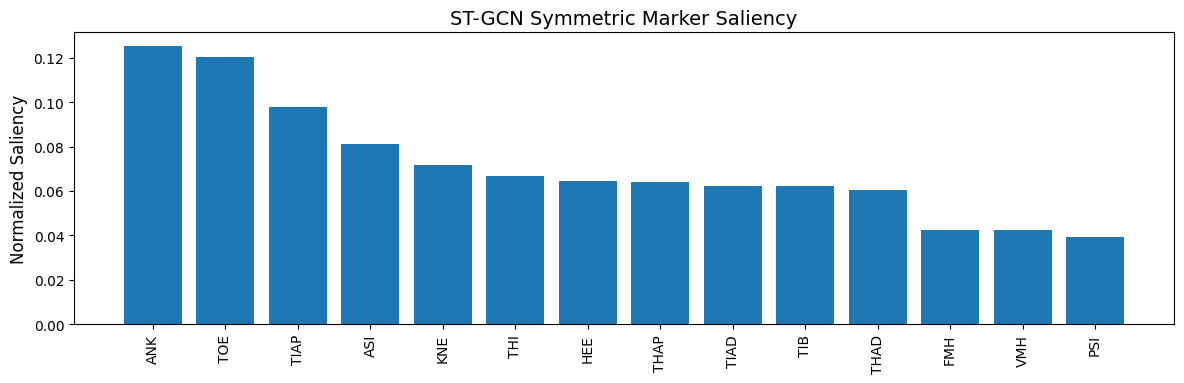

Top influential symmetric markers:
ANK: 0.1252
TOE: 0.1201
TIAP: 0.0980
ASI: 0.0813
KNE: 0.0715
THI: 0.0666
HEE: 0.0645
THAP: 0.0641
TIAD: 0.0622
TIB: 0.0622


In [ ]:
# ========== Saliency Analysis and Visualization ==========

set_seed(5703)

import matplotlib.pyplot as plt

plt.rcParams.update({
    'figure.dpi': 100,
    'savefig.dpi': 100,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.figsize': (12, 4),
})

# Load trained model and compute saliency map
model.load_state_dict(torch.load('baseline_all_marker3.pth'))
model.eval()
merged_saliency = compute_saliency_map_symmetric(model, val_loader, device=device)

# Visualize saliency map
sorted_items = sorted(merged_saliency.items(), key=lambda x: -x[1])
labels, values = zip(*sorted_items)

# Plot saliency scores for markers
plt.figure()
plt.bar(labels, values, color='tab:blue')  
plt.xticks(rotation=90)
plt.ylabel("Normalized Saliency")
plt.title("ST-GCN Symmetric Marker Saliency")
plt.tight_layout()
plt.savefig("merged_saliency.png")
plt.show()


# Print the top 10 most influential symmetric markers
print("Top influential symmetric markers:")
for name, score in sorted_items[:10]:
    print(f"{name}: {score:.4f}")


# marker筛选

In [ ]:
# ========== Evaluate Marker Combinations for Model Performance ==========

# Helper function to filter edges based on the selected markers
def filter_edges(points, all_edges):
    point_set = set(points)
    return [(a, b) for a, b in all_edges if a in point_set and b in point_set]

# Function to evaluate model performance with different subsets of markers based on saliency scores
def evaluate_marker_combinations(
    saliency_dict,
    top_k_list,
    root_dir='random_dataset',
    epochs=500,
    patience=50,
    all_marker_result=None,
    final_model_path='best_marker_combination3.pth'
):
    """
    Evaluate model performance with different top-k marker subsets selected by saliency.

    Args:
        saliency_dict (dict): Symmetric saliency scores, e.g., {'ANK': 0.12, ...}
        top_k_list (list): List of k values for top-k marker selection, e.g., [4, 6, 11]
        root_dir (str): Path to dataset root folder containing 'train' and 'val'
        epochs (int): Maximum number of training epochs
        patience (int): Early stopping patience
        all_marker_result (float or None): Optional val loss of all-marker model for comparison
        final_model_path (str): Path to save the best-performing model

    Returns:
        results (list): List of tuples (Top-k name, selected suffixes, val loss)
    """
    results = []
    sorted_markers = sorted(saliency_dict.items(), key=lambda x: -x[1])
    best_model_file = None

    # Iterate through the specified top-k subsets
    for k in top_k_list:
        selected_suffixes = [name for name, _ in sorted_markers[:k]]
        print(f"\n Training with Top-{k} markers: {selected_suffixes}")

        # Construct marker names for the left leg
        left_points = [f"L{suffix}" for suffix in selected_suffixes]

        # Filter edges for the selected markers
        edges_k = filter_edges(left_points, edges)

        # Add manual edges for small subsets (e.g., Top-4)
        if k == 4: # For the top-4 subset, add specific additional connections
            manual_edges = [
                ('LANK', 'LTIAP'),
                ('LTIAP', 'LASI')
            ]
            edges_k += manual_edges

        # Build adjacency matrix for the selected markers
        A_k = build_adjacency_matrix(left_points, edges_k)

        # Prepare datasets and loaders
        train_set = KAMDataset(os.path.join(root_dir, 'train'), selected_suffixes)
        val_set = KAMDataset(os.path.join(root_dir, 'val'), selected_suffixes)
        train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_set, batch_size=64, shuffle=False, collate_fn=collate_fn)

        # Build and train the model
        A_k = build_adjacency_matrix(left_points, edges_k).to(device)
        model = STGCNRegressor(A=A_k, num_joints=len(left_points)).to(device)
        model_save_path = f"STCGN_top_{k}.pth"
        train_model(model, train_loader, val_loader, epochs=epochs, patience=patience, save_path=model_save_path)
        model.load_state_dict(torch.load(model_save_path))
        model.to(device)

        # Evaluate validation loss
        model.eval()
        total_val_loss = 0
        total_count = 0
        with torch.no_grad():
            for x, y, m in val_loader:
                x = x.to(device)
                y = y.to(device)
                m = m.to(device)
                pred = model(x, m)
                loss = masked_mse_loss(pred, y, m)
                total_val_loss += loss.item() * x.size(0)
                total_count += x.size(0)

        avg_val_loss = total_val_loss / total_count
        results.append((f"Top-{k}", selected_suffixes, avg_val_loss))
        print(f" Top-{k} markers Val Loss: {avg_val_loss:.6f}")

        # Track the best model file based on validation loss
        if best_model_file is None or avg_val_loss < min([r[2] for r in results[:-1]]):
            best_model_file = model_save_path

    # Add all-marker baseline result (if provided)
    if all_marker_result is not None:
        results.append(("All", "All markers", all_marker_result))
        print(f"\n Included all markers baseline Val Loss: {all_marker_result:.6f}")

    # Report the best-performing marker combination
    best = min(results, key=lambda x: x[2]) # Find the combination with the lowest validation loss
    print("\n Best marker combination:")
    print(f"{best[0]} markers: {best[1]}")
    print(f"Val Loss: {best[2]:.6f}")

    # Save best model
    if best_model_file is not None:
        import shutil
        shutil.copyfile(best_model_file, final_model_path)
        print(f" Best model saved to: {final_model_path}")

    return results,best[1]


In [ ]:
# ========== Evaluate Top Marker Combinations ==========

set_seed(5703)

# Load trained model and compute saliency map
model.load_state_dict(torch.load('baseline_all_marker3.pth'))
model.eval()
merged_saliency = compute_saliency_map_symmetric(model, val_loader, device=device)

# Evaluate Different Marker Combinations 
top_k_list = [4, 11, 14]
results, best_markers = evaluate_marker_combinations(
    merged_saliency,
    top_k_list=top_k_list,
    all_marker_result=None,
    final_model_path='best_marker_combination3.pth'
)

# ========== Load Best Marker Subset and Evaluate on Test Set ==========  

# Build the graph structure for the best marker subset
left_points = [f"L{suffix}" for suffix in best_markers]
edges_k = filter_edges(left_points, edges)
A_k = build_adjacency_matrix(left_points, edges_k).to(device)

# Load the best-performing model
model = STGCNRegressor(A=A_k, num_joints=len(left_points)).to(device)
model.load_state_dict(torch.load('best_marker_combination3.pth'))
model.eval()

test_set = KAMDataset('random_dataset/test', selected_markers=best_markers)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Evaluate the model on the test set
evaluate_model(model, test_loader)



 Training with Top-4 markers: ['ANK', 'TOE', 'TIAP', 'ASI']
Loaded 2336 samples (using 4 markers)
Loaded 292 samples (using 4 markers)
Epoch 1, Train Loss: 3.1022, Val Loss: 2.3000
Epoch 2, Train Loss: 2.0067, Val Loss: 1.9235
Epoch 3, Train Loss: 1.7770, Val Loss: 1.7439
Epoch 4, Train Loss: 1.6803, Val Loss: 1.9119
Epoch 5, Train Loss: 1.4894, Val Loss: 1.5931
Epoch 6, Train Loss: 1.3901, Val Loss: 1.5190
Epoch 7, Train Loss: 1.3520, Val Loss: 1.4763
Epoch 8, Train Loss: 1.3309, Val Loss: 1.5196
Epoch 9, Train Loss: 1.3247, Val Loss: 1.3125
Epoch 10, Train Loss: 1.2001, Val Loss: 1.2041
Epoch 11, Train Loss: 1.1799, Val Loss: 1.1935
Epoch 12, Train Loss: 1.1673, Val Loss: 1.1541
Epoch 13, Train Loss: 1.1649, Val Loss: 1.2488
Epoch 14, Train Loss: 1.1346, Val Loss: 1.1727
Epoch 15, Train Loss: 1.1051, Val Loss: 1.2581
Epoch 16, Train Loss: 1.0505, Val Loss: 1.1120
Epoch 17, Train Loss: 1.0229, Val Loss: 1.0077
Epoch 18, Train Loss: 1.0229, Val Loss: 1.0393
Epoch 19, Train Loss: 0.998

In [ ]:
# ========== Visualize Average KAM Curves ==========

# Function to plot average predicted vs. ground truth KAM curves
def plot_average_kam_curve(model, dataset, device='cuda', save_path=None, show=True):
    import matplotlib.pyplot as plt

    model = model.to(device)
    model.eval()

    all_true = []
    all_pred = []

    max_length = 0
    for idx in range(len(dataset)):
        sample = dataset[idx]
        x = sample['input'].unsqueeze(0).to(device)
        y = sample['target'].unsqueeze(0).to(device)
        T = x.shape[1]
        mask = torch.ones((1, T), dtype=torch.bool).to(device)

        with torch.no_grad():
            pred = model(x, mask)

        true_kam = y.squeeze(0).cpu().numpy()
        pred_kam = pred.squeeze(0).cpu().numpy()
        length = min(len(true_kam), len(pred_kam))
        max_length = max(max_length, length)

        all_true.append(true_kam[:length])
        all_pred.append(pred_kam[:length])

    # Pad all sequences to the maximum length with NaN
    def pad_with_nan(seq_list, max_len):
        return np.array([
            np.pad(seq, (0, max_len - len(seq)), constant_values=np.nan)
            for seq in seq_list
        ])

    all_true_padded = pad_with_nan(all_true, max_length)
    all_pred_padded = pad_with_nan(all_pred, max_length)

    # Compute mean curves over valid (non-NaN) values
    mean_true_curve = np.nanmean(all_true_padded, axis=0)
    mean_pred_curve = np.nanmean(all_pred_padded, axis=0)

    # Plot the mean curves
    plt.figure(figsize=(10, 5))
    plt.plot(mean_true_curve, label='Mean Ground Truth', linewidth=2)
    plt.plot(mean_pred_curve, label='Mean Prediction', linestyle='--')
    plt.xlabel('Frame')
    plt.ylabel('KAM')
    plt.title('ST-GCN Mean KAM Curve Across All Samples')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        plt.close()
    elif show:
        plt.show()


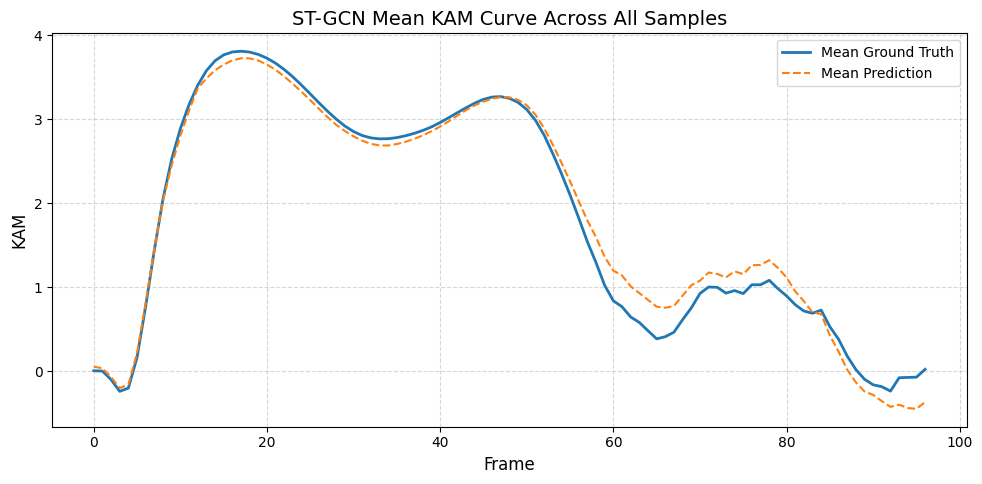

In [ ]:
# Plot the average KAM curve for the test set
plot_average_kam_curve(model, test_set, device='cuda')


In [ ]:
# ========== Extract Peak KAM Metrics ==========

# Function to extract peak KAM values and their prediction errors
def extract_peak_kam_metrics(model, dataset, save_csv_path='results/peak_kam_summary.csv', device=device):
    model = model.to(device)
    model.eval()
    records = []

    for idx in range(len(dataset)):
        sample = dataset[idx]
        x = sample['input'].unsqueeze(0).to(device)      # (1, T, N, D)
        y = sample['target'].unsqueeze(0).to(device)     # (1, T)
        T = x.shape[1]
        mask = torch.ones((1, T), dtype=torch.bool).to(device)
        filename = sample['filename']

        with torch.no_grad():
            pred = model(x, mask)  # (1, T)

        # Extract KAM values
        pred_kam = pred.squeeze(0).cpu().numpy()
        true_kam = y.squeeze(0).cpu().numpy()

        # Split sequence into two halves to identify the first and second peaks
        mid = T // 2
        true_kam1 = np.max(true_kam[:mid]) if mid > 0 else np.nan
        true_kam2 = np.max(true_kam[mid:]) if mid < T else np.nan
        pred_kam1 = np.max(pred_kam[:mid]) if mid > 0 else np.nan
        pred_kam2 = np.max(pred_kam[mid:]) if mid < T else np.nan

        records.append({
            'n': filename,
            'peak KAM1 Actual': true_kam1,
            'peak KAM1 Predict': pred_kam1,
            'peak KAM2 Actual': true_kam2,
            'peak KAM2 Predict': pred_kam2,
        })

    # Save results to a CSV file
    df = pd.DataFrame(records)
    df.to_csv(save_csv_path, index=False)
    print(f"{save_csv_path}")
    return df


In [ ]:
from numpy import mean, std

# Calculate and save peak KAM metrics
df = extract_peak_kam_metrics(model, test_set, device=device)

# Compute and print Mean Squared Errors (MSE) for the first and second peaks
kam1_mse = mean((df['peak KAM1 Actual'] - df['peak KAM1 Predict'])**2)
kam2_mse = mean((df['peak KAM2 Actual'] - df['peak KAM2 Predict'])**2)

print(f"Peak KAM1 MSE  → Mean = {kam1_mse:.6f}")
print(f"Peak KAM2 MSE  → Mean = {kam2_mse:.6f}")

results/peak_kam_summary.csv
Peak KAM1 MSE  → Mean = 0.703015
Peak KAM2 MSE  → Mean = 0.555820
